# Libraries

In [1]:
import  pandas as pd
import  numpy as np
import  pickle
import  plotly.express as px
import  matplotlib.pyplot as plt
import  plotly.graph_objs as go
from    sklearn.impute          import SimpleImputer
from    imblearn.over_sampling  import SMOTE
from    sklearn.preprocessing   import StandardScaler
from    scipy.stats             import zscore
from    sklearn.ensemble        import RandomForestClassifier
from    sklearn.model_selection import RandomizedSearchCV
from    sklearn.model_selection import cross_validate
from    sklearn.metrics         import make_scorer
from    sklearn.metrics         import roc_auc_score

In [2]:
RANDOM_SEED = np.random.seed(0)

In [3]:
cd ..\

c:\Users\victo\Downloads\00. Estudo Data Science\aps_failure_truck_prediction


c:\Users\victo\Downloads\00. Estudo Data Science\aps_failure_truck_prediction\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Train

In [4]:
df_train = pd.read_csv('data\\original\\air_system_previous_years.csv',
                       encoding='utf-8',
                       na_values=['na']
                      )
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [5]:
df_train.dtypes

class      object
aa_000      int64
ab_000    float64
ac_000    float64
ad_000    float64
           ...   
ee_007    float64
ee_008    float64
ee_009    float64
ef_000    float64
eg_000    float64
Length: 171, dtype: object

In [6]:
df_train.isna().sum().sort_values(ascending=False)

br_000    49264
bq_000    48722
bp_000    47740
bo_000    46333
ab_000    46329
          ...  
cj_000      338
ci_000      338
bt_000      167
aa_000        0
class         0
Length: 171, dtype: int64

In [7]:
df_train['class'].value_counts()

class
neg    59000
pos     1000
Name: count, dtype: int64

In [8]:
# Calculate events proportion
total     = df_train.shape[0]
non_event = df_train[df_train['class'] == 'neg'].shape[0]
event     = df_train[df_train['class'] == 'pos'].shape[0]

non_event_percent = round(non_event / total * 100, 2)
event_percent     = round(event / total * 100, 2)

non_event_percent, event_percent

(98.33, 1.67)

In [9]:
df_train.drop(columns='class').corr()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
aa_000,1.000000,0.073103,-0.032055,-0.001903,0.061971,0.089474,0.018610,0.143153,0.285815,0.495529,...,0.735324,0.739211,0.717810,0.727240,0.726984,0.606232,0.471707,0.248039,0.019865,0.037099
ab_000,0.073103,1.000000,-0.019411,0.047281,0.031031,0.053532,0.008418,0.013658,0.050068,0.068100,...,0.062280,0.098808,0.068790,0.078091,0.048717,0.023867,0.039369,0.074119,0.055590,0.162948
ac_000,-0.032055,-0.019411,1.000000,-0.002380,-0.004997,-0.010554,0.017620,-0.001088,-0.016665,-0.038680,...,-0.013692,-0.008111,-0.009849,-0.011206,-0.021430,-0.029417,0.016908,0.024354,-0.006571,0.014228
ad_000,-0.001903,0.047281,-0.002380,1.000000,-0.000214,-0.000269,-0.000047,-0.000131,-0.000222,-0.000423,...,-0.002090,-0.002047,-0.001940,-0.001667,-0.001398,-0.000829,-0.002161,-0.001050,-0.000102,-0.000120
ae_000,0.061971,0.031031,-0.004997,-0.000214,1.000000,0.823108,-0.000430,-0.000832,0.005057,0.034163,...,0.017338,0.024905,0.017311,0.039967,0.085884,0.052357,-0.010850,-0.008206,0.070886,0.041715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.606232,0.023867,-0.029417,-0.000829,0.052357,0.070306,0.000307,0.044186,0.182990,0.505565,...,0.454833,0.446803,0.437682,0.379892,0.545929,1.000000,0.224938,0.061478,-0.000715,0.002708
ee_008,0.471707,0.039369,0.016908,-0.002161,-0.010850,-0.013976,-0.000823,0.004878,0.009466,0.021151,...,0.453811,0.481392,0.459517,0.406920,0.373871,0.224938,1.000000,0.710056,-0.006991,-0.002833
ee_009,0.248039,0.074119,0.024354,-0.001050,-0.008206,-0.010237,-0.001230,-0.004309,-0.009498,-0.019311,...,0.228248,0.239302,0.224638,0.190667,0.163792,0.061478,0.710056,1.000000,-0.003942,-0.000907
ef_000,0.019865,0.055590,-0.006571,-0.000102,0.070886,0.106281,-0.000072,0.002875,0.011824,0.020560,...,0.007118,0.017480,0.005835,0.050270,0.008461,-0.000715,-0.006991,-0.003942,1.000000,0.282184


# Preprocessing

In [10]:
# Change class to int dummies
map_class = {'neg': 0, 'pos': 1}
df_train['class'] = df_train['class'].map(map_class)

# Features to float
features = df_train.drop(columns='class').columns
df_train[features] = df_train[features].astype(float)

In [11]:
original_mean = df_train[features].mean()
original_std  = df_train[features].std()

In [12]:
# Check for outliers
df_features_zscore = zscore(df_train[features], nan_policy='omit')
df_features_zscore.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.119381,NaN,2.232688,-0.004711,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,0.688022,0.519511,0.235649,0.067657,0.005703,-0.108976,-0.145729,-0.176720,-0.020733,-0.024093
1,-0.180697,NaN,-0.447891,NaN,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,-0.020847,-0.060853,-0.130470,-0.132494,-0.186507,-0.153429,-0.091554,-0.145121,-0.020733,-0.024093
2,-0.125811,NaN,-0.447891,-0.004715,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,-0.145485,-0.094447,-0.018610,0.013932,-0.011516,-0.108938,-0.097000,-0.165892,-0.020733,-0.024093
3,-0.407928,-0.205008,-0.447891,-0.004716,-0.042213,-0.004799,-0.010823,-0.02853,-0.057251,-0.115886,...,-0.385321,-0.388505,-0.381473,-0.351374,-0.311507,-0.200384,-0.308627,-0.176720,0.894847,3.599684
4,0.010572,NaN,-0.447889,-0.004707,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,0.152763,0.034351,-0.034611,-0.041710,-0.043122,-0.020087,0.656774,-0.151062,-0.020733,-0.024093


In [13]:
zscore_interval_95_percent = 1.645

# Replace outliers with NaN
remove_outliers = np.where((df_features_zscore > zscore_interval_95_percent) | (df_features_zscore < -zscore_interval_95_percent),
                            np.nan,
                            df_features_zscore
                          )
df_features_zscore_no_outliers = pd.DataFrame(remove_outliers,
                                              columns=df_features_zscore.columns,
                                              index=df_features_zscore.index
                                              )
df_features_zscore_no_outliers.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.119381,NaN,NaN,-0.004711,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,0.688022,0.519511,0.235649,0.067657,0.005703,-0.108976,-0.145729,-0.176720,-0.020733,-0.024093
1,-0.180697,NaN,-0.447891,NaN,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,-0.020847,-0.060853,-0.130470,-0.132494,-0.186507,-0.153429,-0.091554,-0.145121,-0.020733,-0.024093
2,-0.125811,NaN,-0.447891,-0.004715,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,-0.145485,-0.094447,-0.018610,0.013932,-0.011516,-0.108938,-0.097000,-0.165892,-0.020733,-0.024093
3,-0.407928,-0.205008,-0.447891,-0.004716,-0.042213,-0.004799,-0.010823,-0.02853,-0.057251,-0.115886,...,-0.385321,-0.388505,-0.381473,-0.351374,-0.311507,-0.200384,-0.308627,-0.176720,0.894847,NaN
4,0.010572,NaN,-0.447889,-0.004707,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,0.152763,0.034351,-0.034611,-0.041710,-0.043122,-0.020087,0.656774,-0.151062,-0.020733,-0.024093


In [14]:
# Replace outliers with NaN on original train dataset
df_train_no_outliers = df_train.copy()
for column in df_features_zscore_no_outliers:
    for i, row in df_features_zscore_no_outliers.iterrows():
        if np.isnan(row[column]):
            df_train_no_outliers.loc[i, column] = np.nan

In [15]:
df_train_no_outliers.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698.0,NaN,NaN,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040.0,NaN,228.0,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0,12.0,0.0,70.0,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,NaN
4,0,60874.0,NaN,1368.0,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [16]:
df_train_no_outliers.dropna(how='all', axis=1, inplace=True)

features_no_outliers = df_train_no_outliers.drop(columns='class').columns

In [17]:
# Use the median to replace NaN values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(df_train_no_outliers[features_no_outliers])

# Save the imputer to a file
with open('train_artifacts\\simple_imputer.pkl', 'wb') as file:
    pickle.dump(imputer, file)

In [18]:
# Load the imputer from the file
with open('train_artifacts\\simple_imputer.pkl', 'rb') as file:
    imputer = pickle.load(file)

df_train_no_outliers[features_no_outliers] = imputer.transform(df_train_no_outliers[features_no_outliers])
df_train_no_outliers[features_no_outliers].isna().sum().sum()

np.int64(0)

In [19]:
# Balance train data minority class
X_train = df_train_no_outliers[features_no_outliers]
target  = 'class'
y_train = df_train_no_outliers[target]

oversample = SMOTE(sampling_strategy='minority', random_state=RANDOM_SEED)
oversample.fit(X_train, y_train)
# Save the oversample to a file
with open('train_artifacts\\oversample.pkl', 'wb') as file:
    pickle.dump(oversample, file)

In [20]:
# Load the oversample from the file
with open('train_artifacts\\oversample.pkl', 'rb') as file:
    oversample = pickle.load(file)

X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)

In [21]:
df_train_balanced = X_train_balanced.join(y_train_balanced)
df_train_balanced.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,76698.0,0.0,74.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,...,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0,0
1,33058.0,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,...,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0,0
2,41040.0,0.0,228.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0,0
3,12.0,0.0,70.0,66.0,0.0,10.0,0.0,0.0,0.0,318.0,...,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,0.0,0
4,60874.0,0.0,1368.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,...,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0,0


In [22]:
# Calculate events proportion
total     = df_train_balanced.shape[0]
non_event = df_train_balanced[df_train_balanced['class'] == 0].shape[0]
event     = df_train_balanced[df_train_balanced['class'] == 1].shape[0]

non_event_percent = round(non_event / total * 100, 2)
event_percent     = round(event / total * 100, 2)

non_event_percent, event_percent

(50.0, 50.0)

# Model

## Functions

In [40]:
def calculate_feature_importance(model):
    # Calculate feature importance (Gini)
    feat_importance    = model.feature_importances_
    df_feat_importance = pd.DataFrame({'feature':    model.feature_names_in_,
                                       'importance': feat_importance}
                                      ).sort_values('importance', ascending=True)

    plt.figure(figsize=(8, 4))
    plt.boxplot(x=df_feat_importance['importance'], vert=False)
    plt.xlabel('Importance')
    plt.title('Feature importance distribution')

    # Plot the 20 higher features importance
    plt.figure(figsize=(8, 4))
    plt.barh(df_feat_importance['feature'][-20:], df_feat_importance['importance'][-20:])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Top 20 feature importance')

In [49]:
def plot_cross_validation_score(cv_results, score):
    # Create a line plot
    plot_fig, plot_ax = plt.subplots(figsize=(8, 4))
    plot_ax.plot(cv_results[f'train_{score}'],
                 marker='o',
                 linestyle='-',
                 color='blue',
                 label='Train'
                )
    plot_ax.plot(cv_results[f'test_{score}'],
                 marker='o',
                 linestyle='-',
                 color='red',
                 label='Validation'
                )
    plot_ax.set_xlabel('Iteration')
    plot_ax.set_xticks(len(cv_results[f'train_{score}']))
    plot_ax.set_ylabel('Score')
    plot_ax.set_title(f'Cross-validation {score} score')
    plot_ax.legend()
    plot_ax.grid(True)

In [42]:
def create_hyper_parameters_range(parameters: dict):
    range_n_estimators = np.arange(start=round(parameters.get('model_parameters')['n_estimators'][0], 2),
                                   stop=round(parameters.get('model_parameters')['n_estimators'][-1], 2),
                                   step=1
                                   )
    range_max_depth = np.arange(start=round(parameters.get('model_parameters')['max_depth'][0], 2),
                                stop=round(parameters.get('model_parameters')['max_depth'][-1], 2),
                                step=1
                                )
    range_min_samples_split = np.arange(start=round(parameters.get('model_parameters')['min_samples_split'][0], 2),
                                        stop=round(parameters.get('model_parameters')['min_samples_split'][-1], 2),
                                        step=0.1
                                        )
    range_min_samples_leaf = np.arange(start=round(parameters.get('model_parameters')['min_samples_leaf'][0], 2),
                                       stop=round(parameters.get('model_parameters')['min_samples_leaf'][-1], 2),
                                       step=1
                                       )
    param_distributions = {'n_estimators'     : range_n_estimators,
                           'max_depth'        : range_max_depth,
                           'min_samples_split': range_min_samples_split,
                           'min_samples_leaf' : range_min_samples_leaf
                          }
    
    return param_distributions

## Parameters

In [47]:
parameters_rand_forest = {
    "model_parameters": {
        "n_estimators": [5, 200],
        "criterion": ["gini"],
        "max_depth": [3, 13],
        "min_samples_split": [0.2, 1],
        "min_samples_leaf": [1, 7]
    },
    "cross_validation": {
        "n_iterations": 10,
        "folders": 10,
        "scores": [
            "recall",
            "f1_macro",
            "roc_auc",
            "precision_macro"
        ]
    },
    "maintenance_cost": {
        "no_defect_cost": 10,
        "preventive_cost": 25,
        "corrective_cost": 500
    },
    "target": "class",
    "cutoff": 0.3,
    "model_name": "rand_forest",
    "predict_method": "predict_proba"
}


In [48]:
param_distributions = create_hyper_parameters_range(parameters_rand_forest)

## Random forest

In [25]:
rand_forest = RandomForestClassifier(random_state=RANDOM_SEED, verbose=0)

In [ ]:
random_search = RandomizedSearchCV(estimator=rand_forest,
                                   param_distributions=param_distributions,
                                   verbose=3,
                                   cv=parameters_rand_forest.get('cross_validation')['folders'],
                                   n_iter=parameters_rand_forest.get('cross_validation')['n_iterations'],
                                   random_state=RANDOM_SEED,
                                   scoring=make_scorer(roc_auc_score)
                                   )
random_search.fit(X_train_balanced, y_train_balanced)

In [ ]:
best_params = random_search.best_params_
rand_forest_best_params = RandomForestClassifier(**best_params, random_state=RANDOM_SEED)
rand_forest_best_params.fit(X_train_balanced, y_train_balanced)
print(f'\nBest parameters:\n{best_params}')

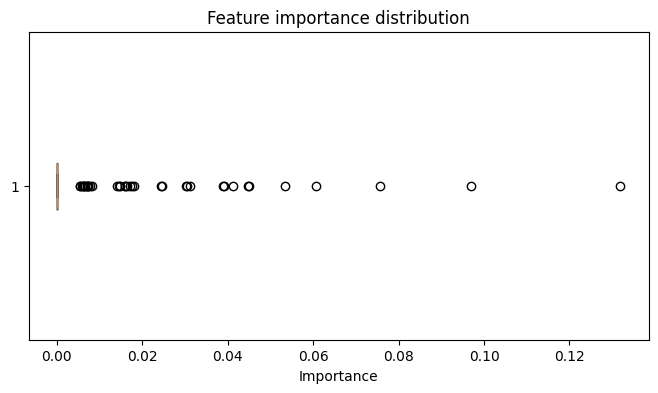

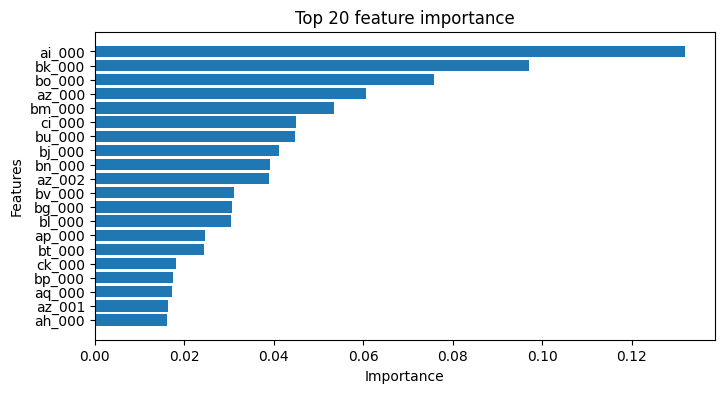

In [31]:
calculate_feature_importance(rand_forest_best_params)

>>>>>>>>> CV recall train mean: 0.9418
>>>>>>>>> CV recall test mean:  0.9416
>>>>>>>>> CV f1_macro train mean: 0.936
>>>>>>>>> CV f1_macro test mean:  0.9359
>>>>>>>>> CV roc_auc train mean: 0.9754
>>>>>>>>> CV roc_auc test mean:  0.9754
>>>>>>>>> CV precision_macro train mean: 0.9361
>>>>>>>>> CV precision_macro test mean:  0.9359


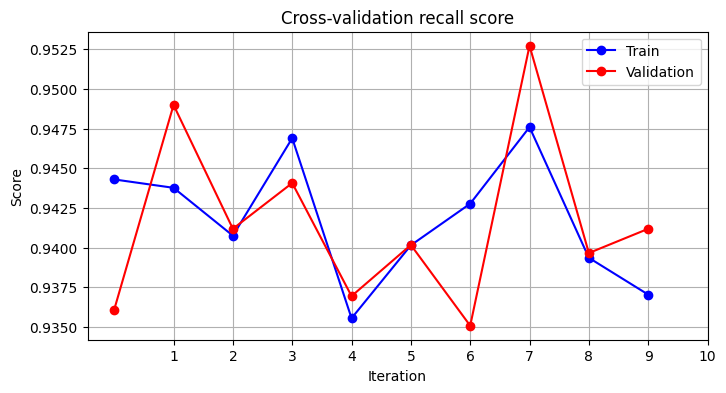

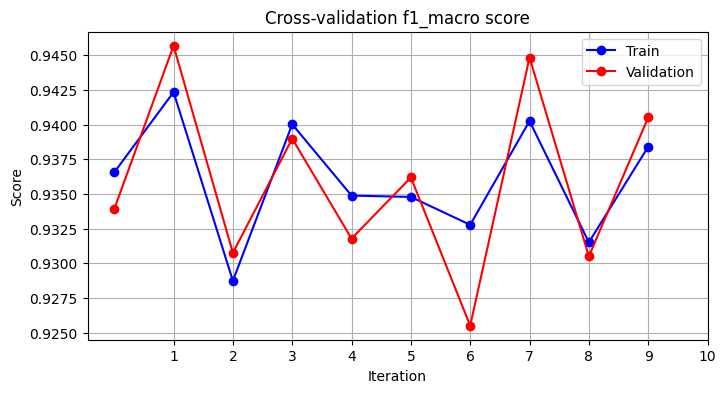

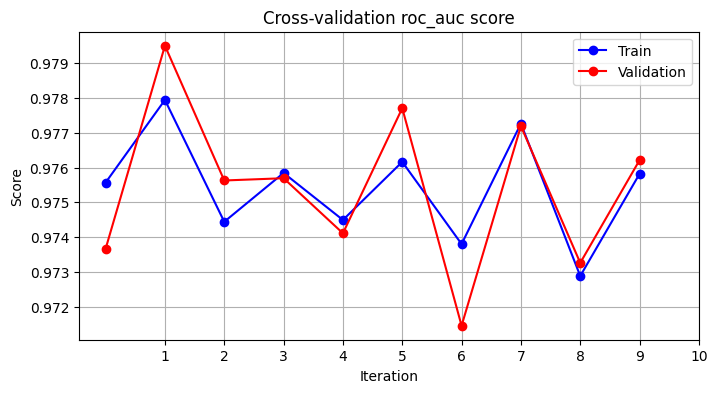

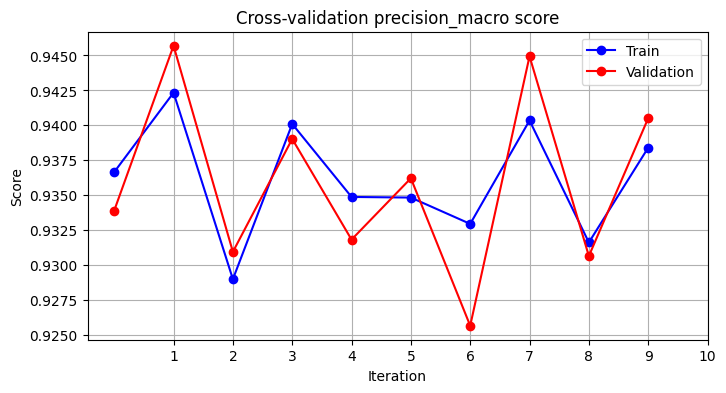

In [ ]:
cv_results_rand_forest = cross_validate(estimator=rand_forest_best_params,
                                        X=X_train_balanced,
                                        y=y_train_balanced,
                                        scoring=parameters_rand_forest.get('cross_validation')['scores'],
                                        cv=parameters_rand_forest.get('cross_validation')['folders'],
                                        verbose=0,
                                        return_train_score=True,
                                        error_score=np.nan
                                        )

# Calculate cross-validation scores
for score in parameters_rand_forest.get('cross_validation')['scores']:
    cv_train_mean = cv_results_rand_forest[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_rand_forest[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_rand_forest, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')